In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from hs2 import herdingspikes
from probe import NeuralProbe, NeuroPixel, BioCam
import numpy as np

%matplotlib inline

In [2]:
# data = h5py.File(data_path, 'r')
# data = np.fromfile(data_path, dtype=np.int16).reshape((1800000,385))

# Probe = NeuroPixel(fps=30000)
Probe = BioCam()
H = herdingspikes(Probe)

In [3]:
# Probe.show(figwidth=12, show_neighbors=[-20])

# Detect and localise spikes

In [4]:
# detectData(data, neighbours, spikefilename, shapefilename, channels, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None, tpre = 1, tpost = 2)
# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames

# data_path = '/home/cole/neuropixeldata/rawDataSample.bin'
data_path = '/data/MEA/neuropixel/rawDataSample.bin'
data_format = 'flat'

data_path = '/data/MEA/LightStim/P29_16_07_14/P29_16_05_14_retina02_left_stim3_fullarray_fullfieldHDF5.brw'
data_format = 'biocam'

to_localize = True
cutout_start = 6#10
cutout_end = 30
threshold = 16

In [5]:
H.DetectFromRaw(data_path,
                to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0)

# # OR

#H.LoadDetected()

print(str(H.spikes.shape[0])+' spikes detected')

3Brain data format: 100
# Sampling rate: 7022
# Number of recorded channels: 4096
# Analysing frames: 912032, Seconds:129.881008418
# Frames before spike in cutout: 7
# Frames after spike in cutout: 15
# tcuts: 19 42
# tInc: 200000
# Analysing 200000 frames; -19 200042
# Analysing 200000 frames; 199981 400042
# Analysing 200000 frames; 399981 600042
# Analysing 200000 frames; 599981 800042
# Analysing 111990 frames; 799981 912032
# Time taken for detection: 0:02:05.120148
# Time per frame: 0:00:00.137188
# Time per sample: 0:00:00.000033


In [6]:
# does not work yet:
# H.PlotTracesChannels(data_path, 1022)

(-3.1509856630824369,
 66.150985663082437,
 -3.1510117733627672,
 66.151011773362768)

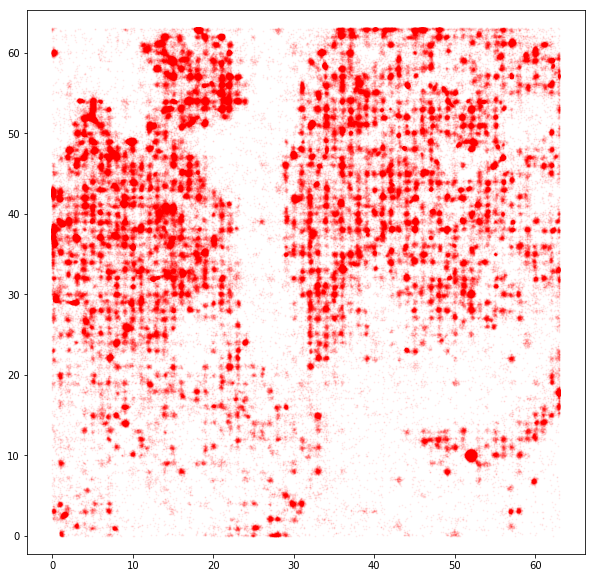

In [7]:
plt.figure(figsize=(10, 10))
H.PlotAll(invert=True, s=1, alpha=0.05)
plt.axis('equal')

# Cluster with DBScan

Number of estimated clusters: 4901


/home/mhennig/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mhennig/.local/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/mhennig/.local/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


CPU times: user 28.5 s, sys: 4.89 s, total: 33.4 s
Wall time: 28.9 s


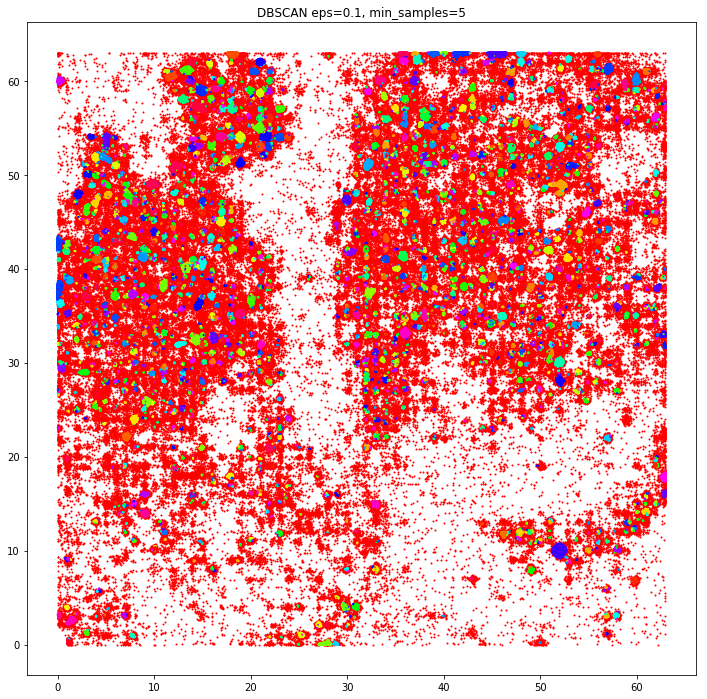

In [8]:
%%time
from sklearn.cluster import DBSCAN

eps = 0.1#15#0.12
alpha = 0.25
min_samples = 5

H.CombinedClustering(eps=eps, alpha=alpha, clustering_algorithm=DBSCAN,
                    min_samples=min_samples, pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

plt.figure(figsize=(12, 12))
H.PlotAll(invert=True, s=1)
plt.title('DBSCAN eps='+str(eps)+', min_samples=5')
# plt.xlim((1350,1600))

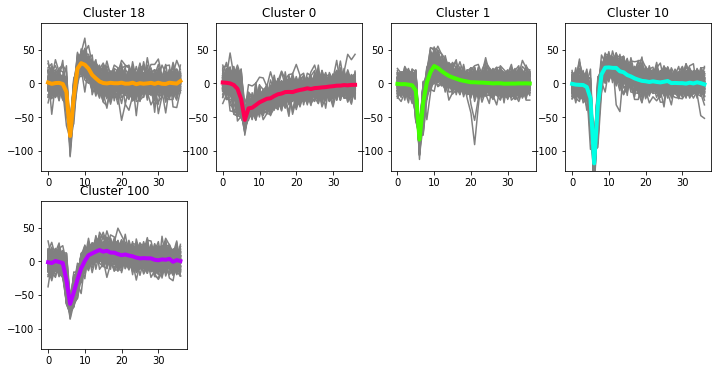

In [9]:
units = (18,0,1,10,100)

H.PlotShapes(units)

# plot all units and unclustered spikes in a small region 

9


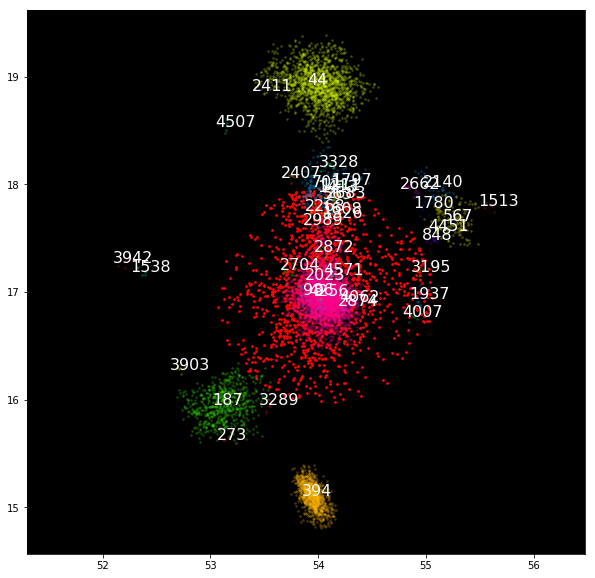

In [33]:
plt.figure(figsize=(10,10))
ax = plt.axes(facecolor='k')

largest = np.argsort(H.clusters['Size']).values[::-1]
cl = largest[2]
print(cl)

cx, cy = H.clusters['ctr_x'][cl],H.clusters['ctr_y'][cl]

# slice out the unclustered spikes
# is there a better way?
inds = np.where(H.spikes.cl==-1)[0]
x,y = H.spikes.x[inds].values, H.spikes.y[inds].values
dists = np.sqrt((cx-x)**2+(cy-y)**2)
spInds = np.where(dists<1)[0]
plt.scatter(x[spInds], y[spInds], c='r', s=3)


dists = np.sqrt((cx-H.clusters['ctr_x'])**2+(cy-H.clusters['ctr_y'])**2)
clInds = np.where(dists<2)[0]
for cl_t in clInds:
    cx, cy = H.clusters['ctr_x'][cl_t],H.clusters['ctr_y'][cl_t]
    inds = np.where(H.spikes.cl==cl_t)[0]
    x,y = H.spikes.x[inds],H.spikes.y[inds]
    plt.scatter(x,y,c=plt.cm.hsv(H.clusters['Color'][cl_t]), s=3,alpha=0.2)
    plt.text(cx-0.1,cy,str(cl_t), fontsize=16, color='w')
plt.axis('equal');


9


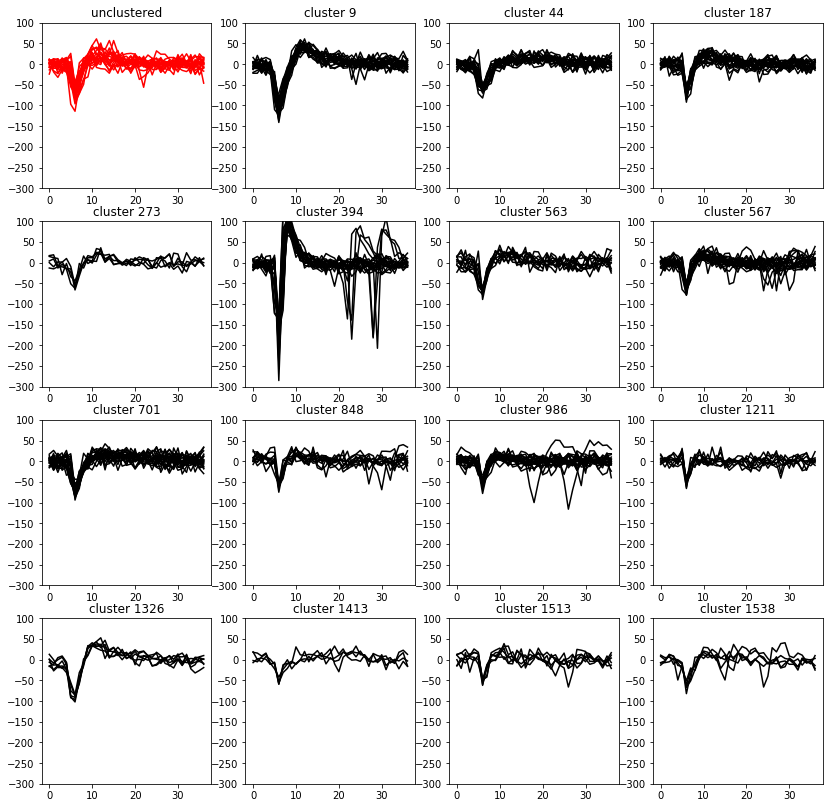

In [34]:
plt.figure(figsize=(14,14))
# ax = plt.axes(facecolor='k')
print(cl)

cx, cy = H.clusters['ctr_x'][cl],H.clusters['ctr_y'][cl]

plt.subplot(4,4,1)
inds = np.where(H.spikes.cl==-1)[0]
x,y = H.spikes.x[inds].values, H.spikes.y[inds].values
dists = np.sqrt((cx-x)**2+(cy-y)**2)
spInds = np.where(dists<2)[0][:20]
for i in inds[spInds]:
    plt.plot(H.spikes.Shape[i],'r')
plt.ylim((-300,100))    
plt.title('unclustered')

dists = np.sqrt((cx-H.clusters['ctr_x'])**2+(cy-H.clusters['ctr_y'])**2)
clInds = np.where(dists<2)[0]
for i,cl_t in enumerate(clInds[:15]):
    plt.subplot(4,4,i+2)
    spInds = np.where(H.spikes.cl==cl_t)[0]
    for i in spInds[:20]:
        plt.plot(H.spikes.Shape[i],'k')
    plt.ylim((-300,100))    
    plt.title('cluster '+str(cl_t))
    



(-300, 100)

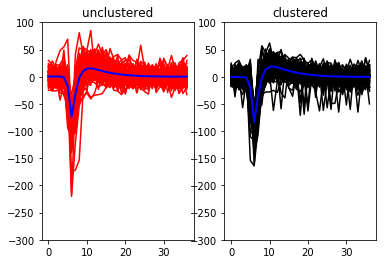

In [35]:
# unclustered events
plt.subplot(121)
inds = np.where(H.spikes.cl==-1)[0]
for i in range(0,200,2):
    plt.plot(H.spikes['Shape'][inds[i]],'r')
plt.plot(np.mean(H.spikes['Shape'][inds]),'b',lw=2)
plt.title('unclustered')
plt.ylim((-300,100))    

plt.subplot(122)
inds = np.where(H.spikes.cl>-1)[0]
for i in range(20,200,2):
    plt.plot(H.spikes['Shape'][inds[i]],'k')
plt.plot(np.mean(H.spikes['Shape'][inds]),'b',lw=2)
plt.title('clustered')
plt.ylim((-300,100))

# Mean Shift Clustering

In [8]:
%%time
# H.CombinedClustering(alpha=40,
#                     bandwidth = 20, bin_seeding=True, min_bin_freq=10,
#                     pca_ncomponents=2, pca_whiten=True,
#                     n_jobs=-1)
H.CombinedClustering(alpha=0.4,
                    bandwidth = 0.3, bin_seeding=True, min_bin_freq=10,
                    pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

plt.figure(figsize=(10, 10))
H.PlotAll(invert=True, s=1)
# plt.xlim((1350,1600))
plt.title("MeanShift, bandwidth=.3, min_bin_freq=10")

total number of seeds: 8320
seeds/job: 2081
using 4 cpus


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min finished


Number of estimated clusters: 980
